### Določanje nivoja proženja

In [1]:
#common libraries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.rcParams['figure.dpi'] = 1000
import numpy as np
import os
from IPython import get_ipython
import pandas as pd
import statistics
from importlib import reload


In [ ]:
import glob
from pathlib import Path


def get_data_fromTXT(folder_path, skip=0, convert_to_float=False):
    """
    Returns list of data from a txt file.
    
    Input parameters:
        - folder_path [string] - path to the folder with txt files. If you wish to read only one txt file, specify the path to that file (it should include .txt suffix)
        - skip [int] - number of lines you wish to skip eg. txt. file has a header,... By default it is set to 0
        - convert_to_float [bool, optional] - True if you wish to convert values to floats.
    Output parameters:
        - data [dict, list] - dictionary of data or list of data in case of only one file. Keyword is file path, value is a list of data in a file
    """
    if ".txt" in folder_path:
        all_data =[]
        cont = open(file = folder_path, mode = "r").readlines()
        cont = cont[skip::]
        data = []
        for j in cont:
            if convert_to_float:
                number = float(j.strip("\n").replace(",", "."))
                data.append(number)
            else:
                data.append(j.rstrip("\n"))
        return data      
    else:
        files = glob.glob(f"{folder_path}/**.txt") 
        all_data = {}
        for i in files:
            cont = open(file = i, mode = "r").readlines()
            cont = cont[skip::]
            data = []
            for j in cont:
                if convert_to_float:
                    number = float(j.strip("\n").replace(",", "."))
                    print(number)
                    data.append(number)
                else:
                   data.append(j.rstrip("\n"))
            #saves data from one file to a dictionary. Key is name of the .txt file
            key = os.path.basename(i).strip(".txt")
            all_data.update({key : data})
        return all_data 


def filter_names(names, exclude=None, include=None, filter_symbol=None):
    """
    Filters given list of names.
    
    Input parameters:
        - names [list] - List of names to filter.
        - exclude [list, optional] - List of names to exclude
        - include [list, optional] - List of names to include
        - filter_symbol [str, optionl] - Option to add a symbol that seperates different strings (eg. If you want to differentiate between 2 and 22, you can input a symbol after the end of the strng so that the new srings are 2[symbol] and 22[symbol])
    
    Output parameters:
        - filtered_names [list] - Filtered list of names. 
    """
    
    if exclude is None:
       exclude = []
    if include is None:
       include = []   
       

    
    filtered_names = []
    if filter_symbol is not None:
        exclude = [el + filter_symbol for el in exclude]
        include = [el + filter_symbol for el in include]
    for name in names:
      # Check if the name is not in the exclude list
        exclude_check = not any(re.search(sub, name, re.IGNORECASE) for sub in exclude)
        include_check = all(substring in name for substring in include)
        if exclude_check and include_check:
        # Check if the name contains all the substrings in include_name list
            filtered_names.append(name)

    return filtered_names

def getFiles_recursive(folder_path, suffix = None, include=None, exclude=None, search_recursive=True):
    """
    Recursively finds files with the specified suffix in the given directory and its subdirectories.

    Input parameters:
        - folder_path [string] - The path to the directory to start the search.
        - suffix [string, optional] - The suffix (file extension) to match. Default is None, suffix is then not checked
        - include [list, optional] - A list of names, that file names must include. If file name include one name but does not include a second it will be returned
        - exclude [list, optional] - A list of folder names or file names to exclude from the search.
        - search_recursive [bool, optional] - Option to change the searching pattern from recursive to only in current directory

    Output parameters:
        - list - A list of file names with the specified suffix found in the directory and its subdirectories.
    """
    if suffix is None:
        sf = ""
    else:
        sf = f".{suffix}"
    
    f_path = Path(folder_path)
    
    if search_recursive:
        files = list(f_path.rglob(f"*{sf}"))
    else:
        files = list(f_path.glob(f"*{sf}"))
        
    f_files =  []
    for i in files:
        if os.path.isfile(i):
            rel_path = Path(i).relative_to(Path(folder_path))
            f_files.append(str(rel_path))
        else:
            continue
    
    filt_rel = filter_names(f_files, exclude=exclude, include=include)   
    
    filtered_files = []
    for i in filt_rel:
       j = os.path.join(folder_path, i)
       filtered_files.append(j)
    
    return filtered_files

In [3]:
files = getFiles_recursive(r"SK1_pon", suffix="txt")

txt_files = {}
positions = []
for f in files:
    name = int(os.path.basename(f).rstrip(".txt").split("_")[1].rstrip("mm"))
    positions.append(name)
    txt = get_data_fromTXT(f, convert_to_float=True)
    txt_files.update({name: txt})

txt_files[15] = list(np.array(txt_files[15]) - 0.2)

sorted_val = dict(sorted(txt_files.items()))
positions = sorted(positions)

In [4]:
fr = 100 #Hz
dt = 1/fr #s
time_total = 30 #s
R = 15. #mm
dx = 1
H_k = 1377. #mm
H_tot = 1486 #mm
A = np.pi * R**2


V_1 = (np.pi * R**2) * H_k
V_2 = (np.pi * R**2)*H_tot - (np.pi * R**2)*H_k

alpha_1 = V_2/(V_1 + V_2)

Ai = []
X = []
for i in positions:
    inner = max(0, i-dx/2)
    outer = min(R, i + dx/2)
    X.append(inner)
    X.append(outer)
    ai = np.pi * (outer**2 - inner**2)
    Ai.append(ai)



In [5]:
def binarise_signal(signal, threshold, high_val=1, low_val=0):
    """
    Convert a numeric signal to a binary signal based on a threshold.

    Input parameters:
        - signal [array-like]: Input numeric signal.
        - threshold [float]: Threshold value.
        - high_val [float, optional]: High bin. value
        - low_val [float, optional]: Low bin. val

    Output parameters:
        - P [array]: Binary signal (1 where signal > threshold, else 0).
    """
    signal = np.asarray(signal)

    P = np.where(signal > threshold, high_val, low_val)
    return P

def alpha_2_i(y_i, threshold, dt):
    """
    Calculates alpha from the given signal and threshold.

    Input parameters:
        - y_i [array]: signal from the phase sensor
        - threshold [float]: threshold for binarisation
        - dt [float]: time between each datapoint
    
        Output parameters:
        - alpha [float]: phase percentage
    """
    time_total = len(y_i) * dt
    y_1 = binarise_signal(y_i, threshold, dt, 0)
    time_high = sum(y_1)
    alpha = time_high/time_total

    return alpha


def alpha_2(y_all, A_i, threshold, dt):
    """
    Calulates global alpha (for the whole pipe).
    """
    upper = []
    for i,j in zip(y_all, Ai):
        alpha_i = alpha_2_i(i, threshold, dt)
        upper.append(alpha_i*j)
    
    alpha_glob = np.sum(np.array(upper))/np.sum(A_i)

    return alpha_glob

def error(threshold, alpha_1, y_all, Ai, dt):
    """
    Calculates error between alpha 1 and alpha 2 (for minimisation)

    """
    alpha2 = alpha_2(y_all, Ai, threshold, dt)

    error = np.abs(alpha_1 - alpha2)

    return float(error)



In [6]:
import numpy as np
from scipy.optimize import minimize_scalar

start = [0]
y_all = list(sorted_val.values())

# Minimize error
res = minimize_scalar(error, bounds=(0, 5), method='bounded', args=(alpha_1, y_all, Ai, dt))

p_thr = res.x
print("Optimal parameter:", res.x)
print("Minimum error:", res.fun)

Optimal parameter: 1.818769828563157
Minimum error: 0.005248797921453496


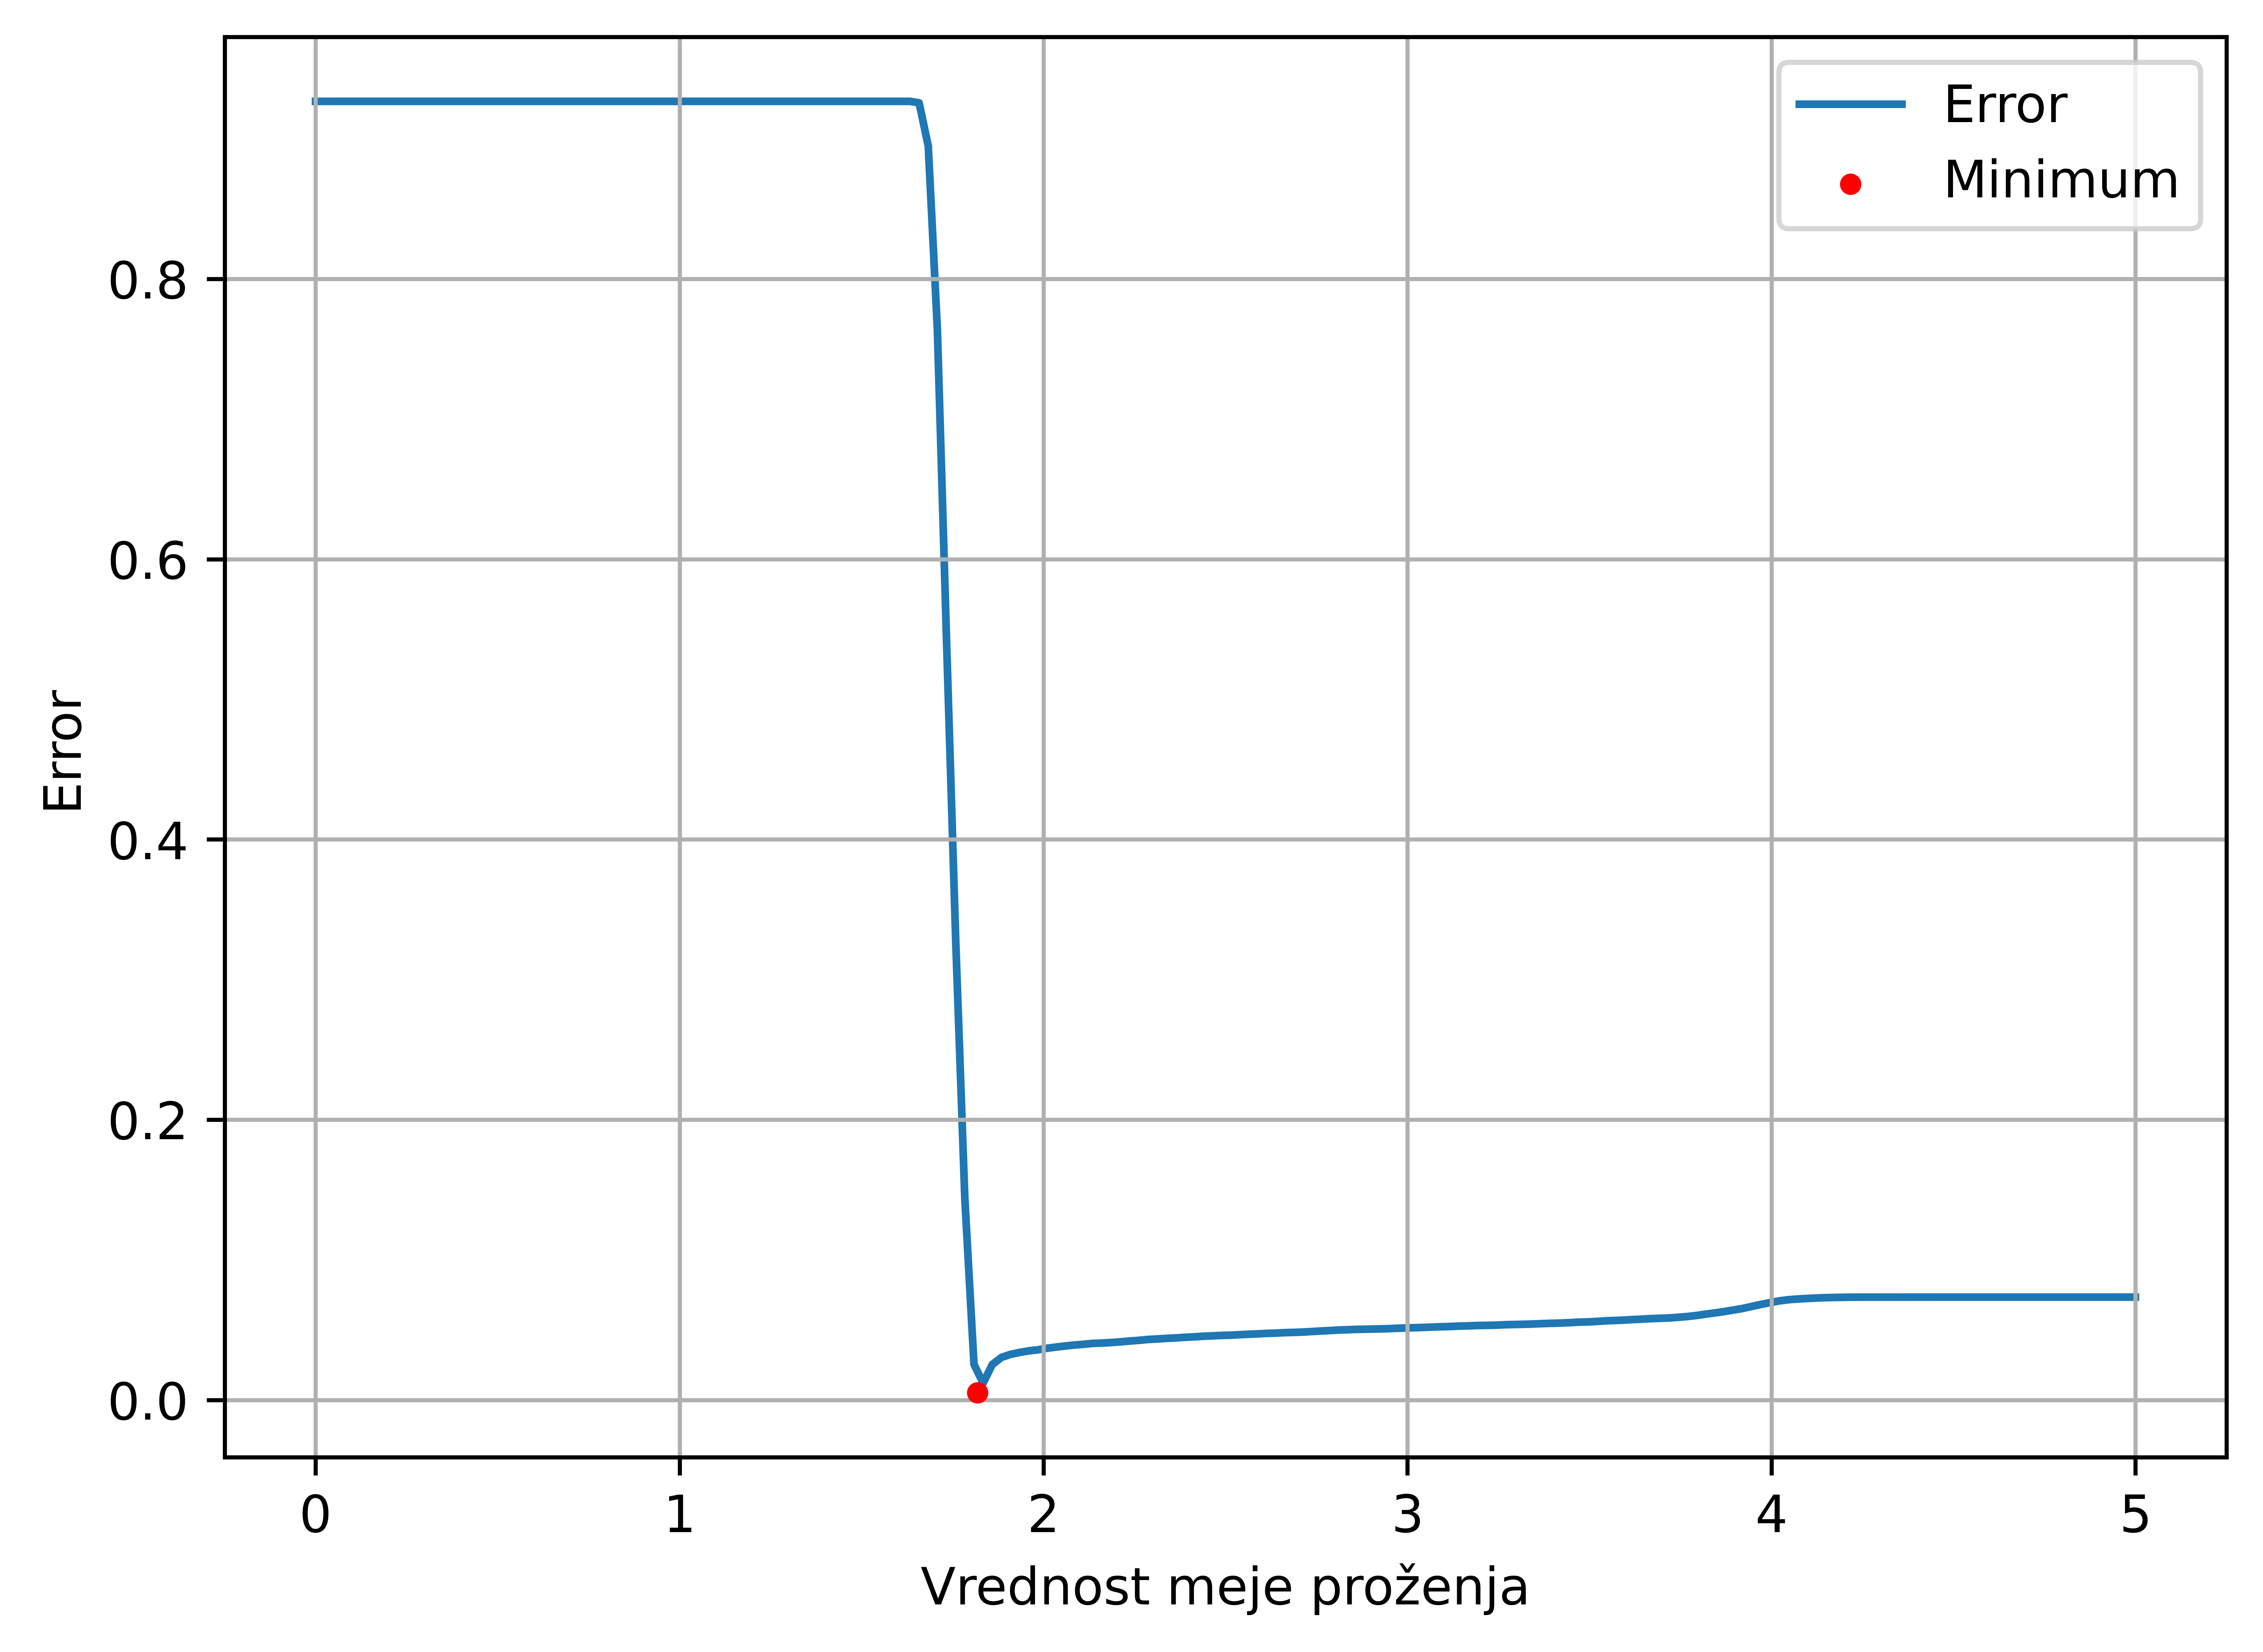

In [7]:
param_values = np.linspace(0, 5, 200)
errors = [error(p, alpha_1, y_all, Ai, dt) for p in param_values]

# Plot
plt.figure(figsize=(7,5))
plt.plot(param_values, errors, label='Error', zorder=1)
plt.scatter(res.x, res.fun, c="red", s=10, label="Minimum", zorder=2)
plt.xlabel('Vrednost meje proženja')
plt.ylabel('Error')
plt.grid(True, zorder=0)
plt.legend()
plt.show()

In [13]:
R_dict = {i: (max(j), min(j)) for i, j in sorted_val.items()}
all_values = [v for values in sorted_val.values() for v in values]
R_max = max(all_values)
R_min = min(all_values)

In [27]:
p_thr

1.818769828563157

In [26]:
print("Alpha 2:", alpha_2(y_all, Ai, p_thr, dt))
print("Alpha 1:", alpha_1)

Alpha 2: 0.07860007652172267
Alpha 1: 0.07335127860026917


In [15]:
from sympy import symbols, Eq, solve

x = symbols('x')
equation = Eq(R_max*x + (1-x)*R_min, p_thr)
solution = solve(equation, x)

print(solution) 

[0.0639888253937630]


In [16]:
alpha_per = []
for key, val in sorted_val.items():
    a = np.mean(alpha_2_i(val, p_thr, dt))
    alpha_per.append(a)
    alpha_per.append(a)

alpha_all = alpha_per[::-1] + alpha_per
X_all = list(np.array(X[::-1])*-1) + X

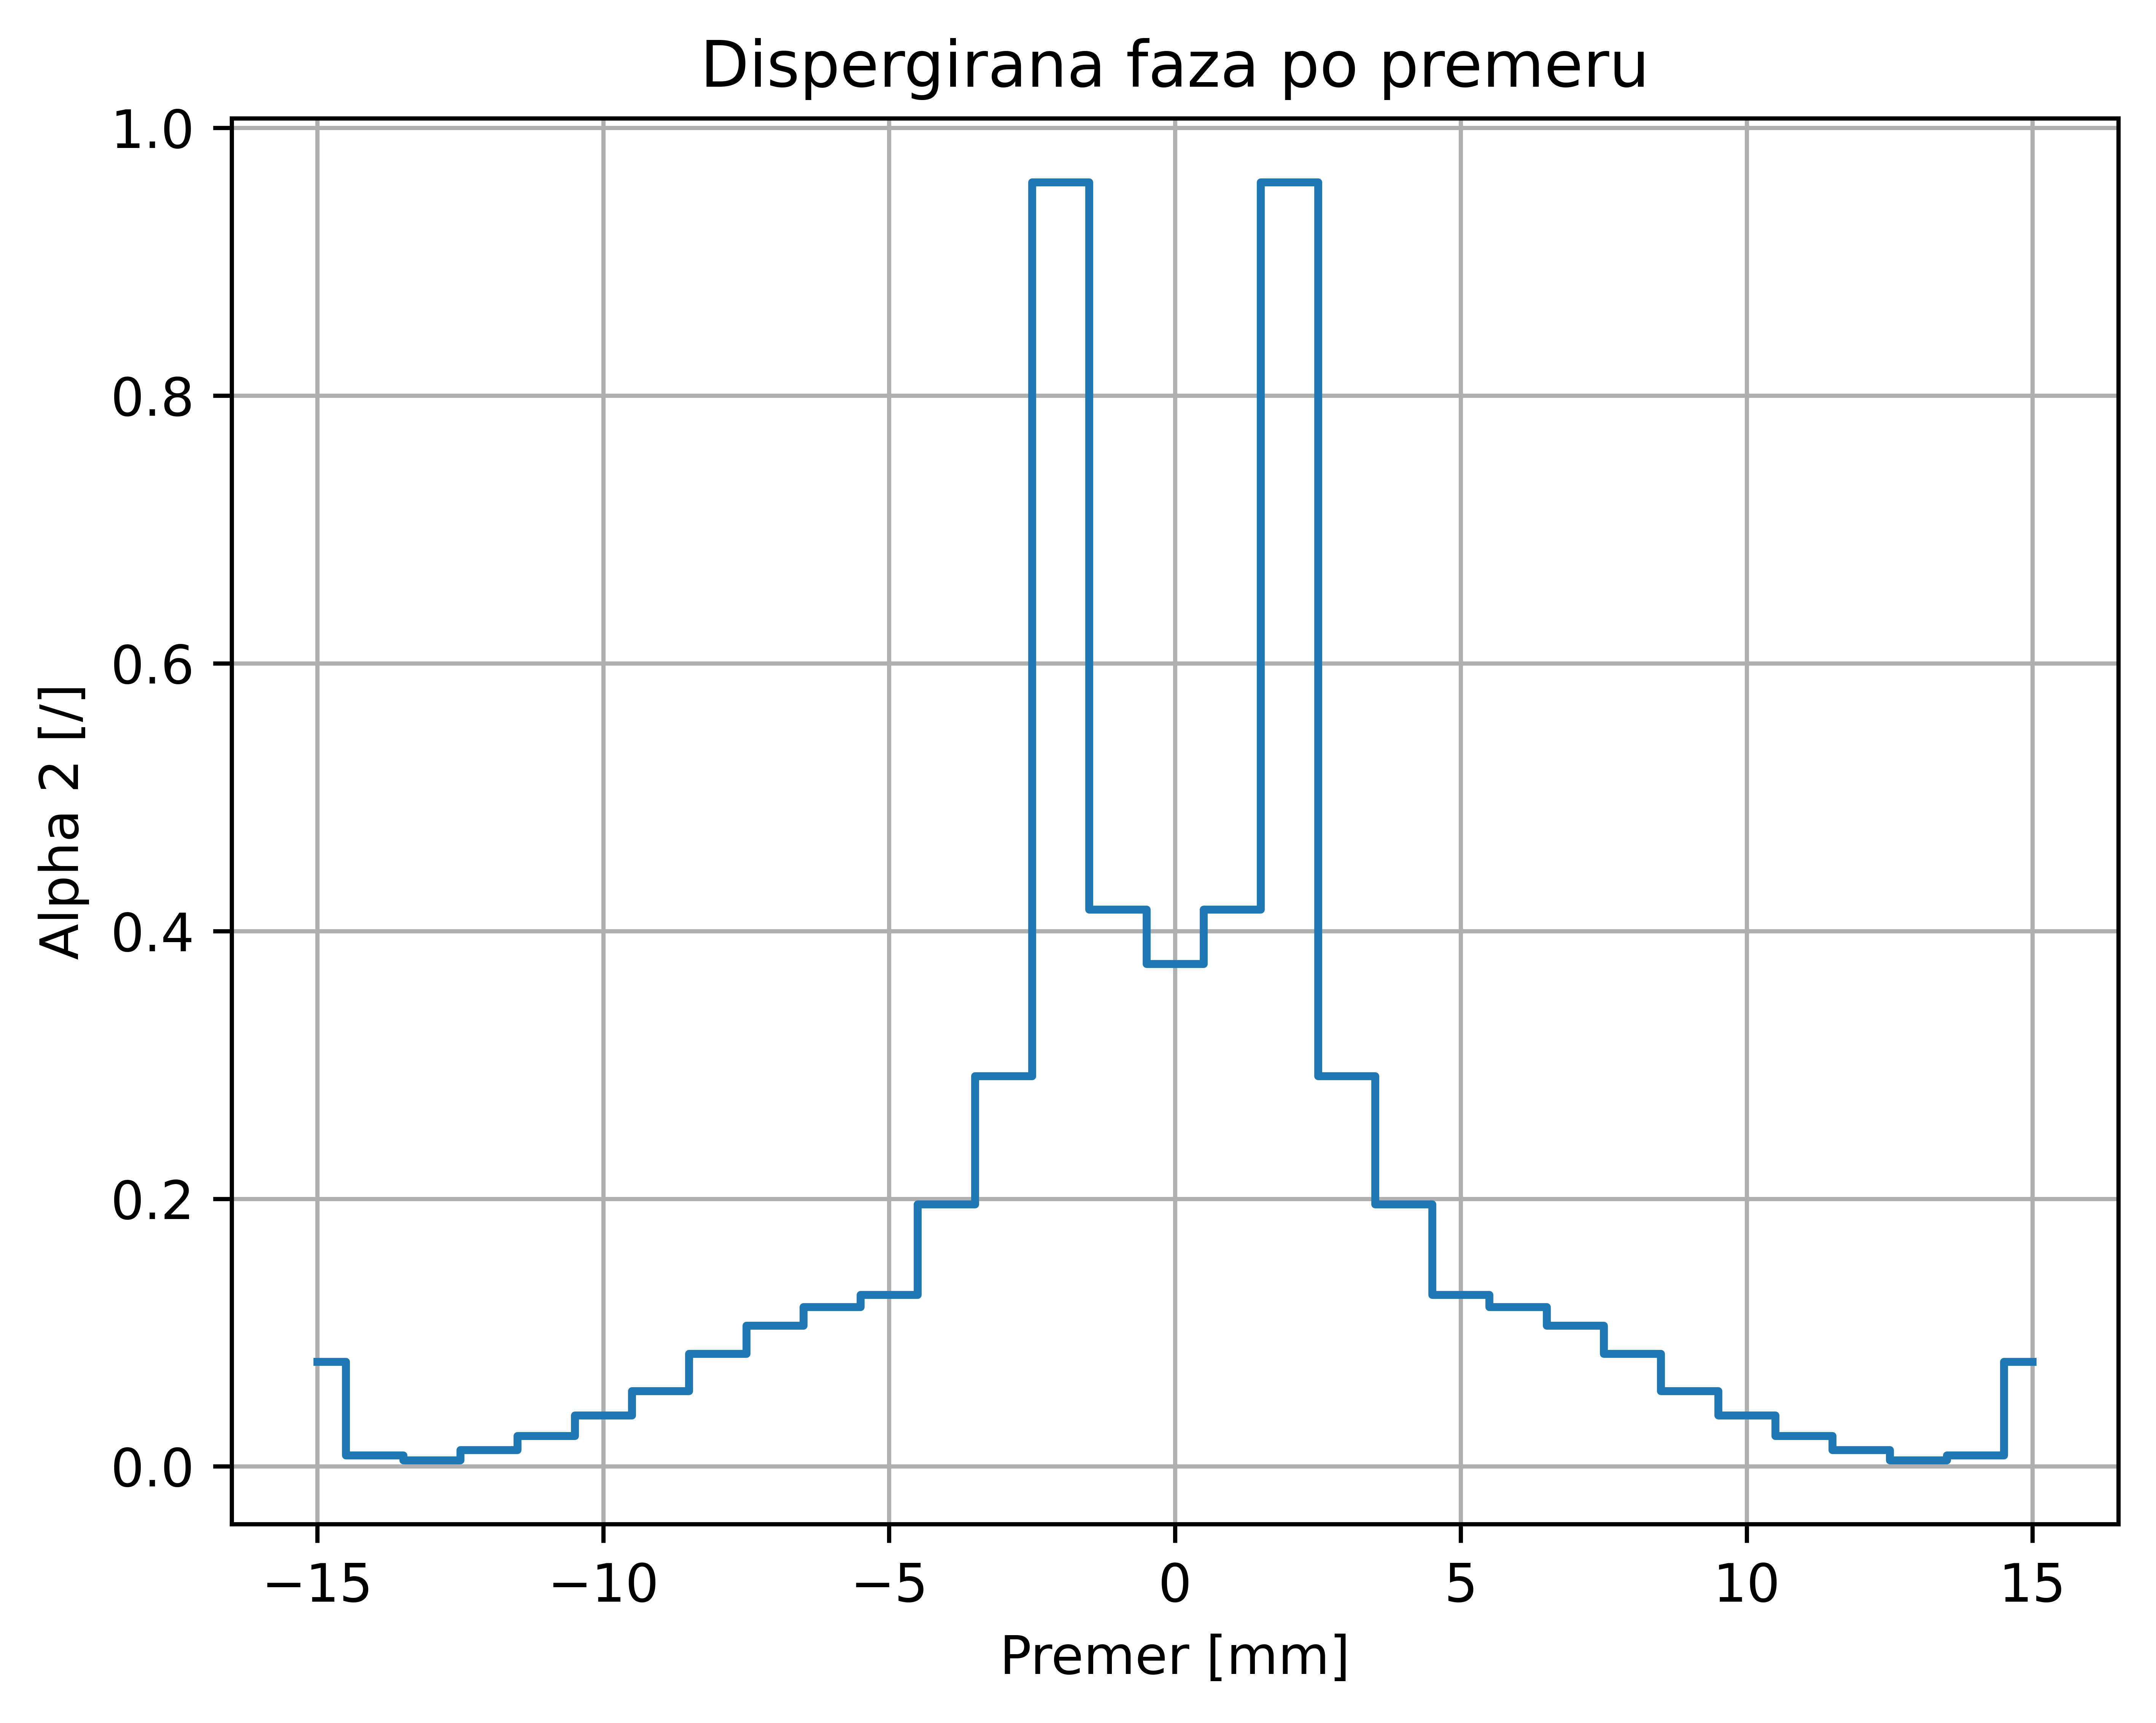

In [17]:
plt.plot(X_all, alpha_all)
plt.title("Dispergirana faza po premeru")
plt.xlabel("Premer [mm]")
plt.ylabel("Alpha 2 [/]")
plt.grid()
plt.show()

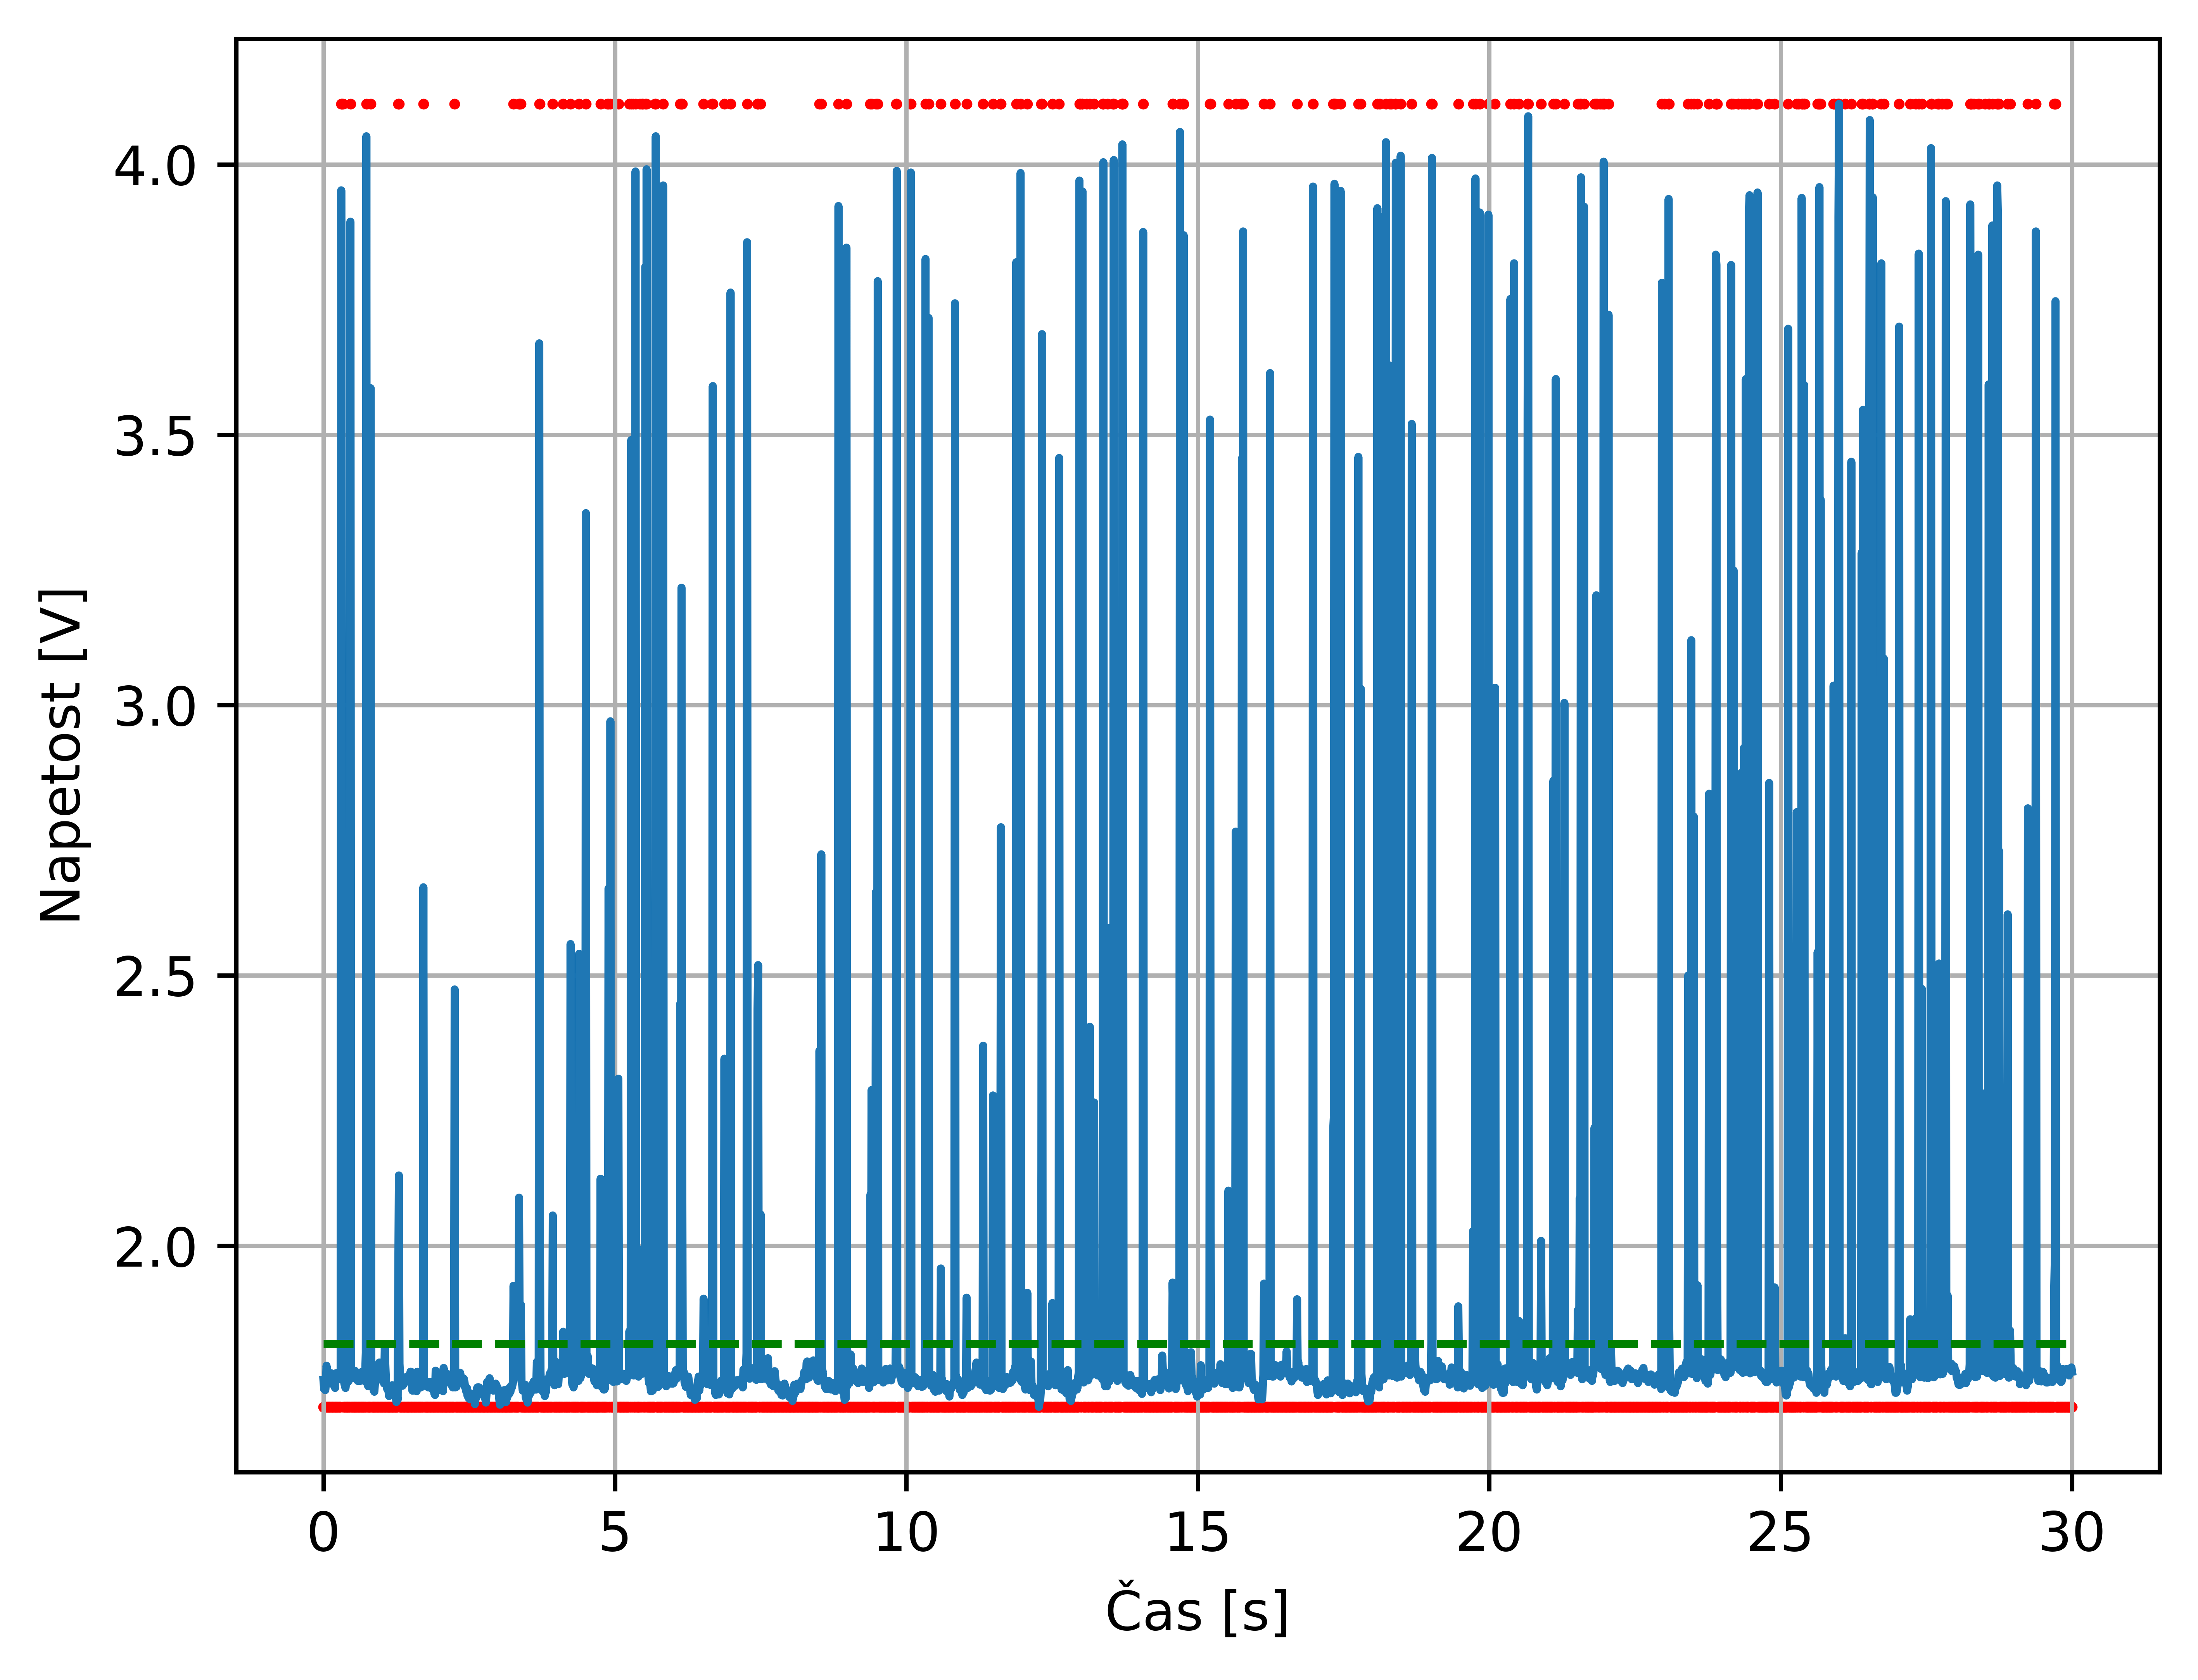

In [21]:
y = txt_files[8]
y_1 = binarise_signal(y, p_thr, max(y), min(y))
time = np.linspace(0, time_total, len(y))

plt.scatter(time, y_1, c="red", s=1)
plt.plot(time, y)
plt.hlines(p_thr, xmin=0, xmax=time_total, colors='green', linestyles='dashed', label='Threshold')
plt.xlabel("Čas [s]")
plt.ylabel("Napetost [V]")
plt.grid()